# Monte Carlo Methods

In this notebook, you will write your own implementations of many Monte Carlo (MC) algorithms.

While we have provided some starter code, you are welcome to erase these hints and write your code from scratch.

### Part 0: Explore BlackjackEnv

We begin by importing the necessary packages.

In [2]:
pip install gym


[notice] A new release of pip is available: 25.0.1 -> 25.2
[notice] To update, run: python3 -m pip install --upgrade pip
Note: you may need to restart the kernel to use updated packages.


In [3]:
import sys
import gym
import numpy as np
if not hasattr(np, 'bool8'):
    np.bool8 = np.bool_
from collections import defaultdict

from plot_utils import plot_blackjack_values, plot_policy

Gym has been unmaintained since 2022 and does not support NumPy 2.0 amongst other critical functionality.
Please upgrade to Gymnasium, the maintained drop-in replacement of Gym, or contact the authors of your software and request that they upgrade.
Users of this version of Gym should be able to simply replace 'import gym' with 'import gymnasium as gym' in the vast majority of cases.
See the migration guide at https://gymnasium.farama.org/introduction/migration_guide/ for additional information.


Use the code cell below to create an instance of the [Blackjack](https://github.com/openai/gym/blob/master/gym/envs/toy_text/blackjack.py) environment.

In [4]:
env = gym.make('Blackjack-v1')

Each state is a 3-tuple of:
- the player's current sum $\in \{0, 1, \ldots, 31\}$,
- the dealer's face up card $\in \{1, \ldots, 10\}$, and
- whether or not the player has a usable ace (`no` $=0$, `yes` $=1$).

The agent has two potential actions:

```
    STICK = 0
    HIT = 1
```
Verify this by running the code cell below.

In [5]:
print(env.observation_space)
print(env.action_space)

Tuple(Discrete(32), Discrete(11), Discrete(2))
Discrete(2)


Execute the code cell below to play Blackjack with a random policy.  

(_The code currently plays Blackjack three times - feel free to change this number, or to run the cell multiple times.  The cell is designed for you to get some experience with the output that is returned as the agent interacts with the environment._)

In [6]:
for i_episode in range(3):
    state, info = env.reset()        # Gymnasium returns (obs, info)
    while True:
        print(state)
        action = env.action_space.sample()
        next_state, reward, terminated, truncated, info = env.step(action)
        done = terminated or truncated   # emulate Gym’s single `done`
        state = next_state
        if done:
            print('End game! Reward:', reward)
            print('You won :)\n' if reward > 0 else 'You lost :(\n')
            break


(13, 10, False)
End game! Reward: -1.0
You lost :(

(15, 2, True)
End game! Reward: 1.0
You won :)

(15, 4, False)
End game! Reward: -1.0
You lost :(



### Part 1: MC Prediction

In this section, you will write your own implementation of MC prediction (for estimating the action-value function).  

We will begin by investigating a policy where the player _almost_ always sticks if the sum of her cards exceeds 18.  In particular, she selects action `STICK` with 80% probability if the sum is greater than 18; and, if the sum is 18 or below, she selects action `HIT` with 80% probability.  The function `generate_episode_from_limit_stochastic` samples an episode using this policy.

The function accepts as **input**:
- `bj_env`: This is an instance of OpenAI Gym's Blackjack environment.

It returns as **output**:
- `episode`: This is a list of (state, action, reward) tuples (of tuples) and corresponds to $(S_0, A_0, R_1, \ldots, S_{T-1}, A_{T-1}, R_{T})$, where $T$ is the final time step.  In particular, `episode[i]` returns $(S_i, A_i, R_{i+1})$, and `episode[i][0]`, `episode[i][1]`, and `episode[i][2]` return $S_i$, $A_i$, and $R_{i+1}$, respectively.

In [7]:
def generate_episode_from_limit_stochastic(bj_env):
    episode = []
    state, info = bj_env.reset()   # unpack obs and info
    while True:
        player_sum, dealer_card, usable_ace = state
        probs = [0.8, 0.2] if player_sum > 18 else [0.2, 0.8]
        action = np.random.choice(np.arange(2), p=probs)
        next_state, reward, terminated, truncated, info = bj_env.step(action)
        done = terminated or truncated
        episode.append((state, action, reward))
        state = next_state
        if done:
            break
    return episode

Execute the code cell below to play Blackjack with the policy.

(*The code currently plays Blackjack three times - feel free to change this number, or to run the cell multiple times.  The cell is designed for you to gain some familiarity with the output of the `generate_episode_from_limit_stochastic` function.*)

In [8]:
for i in range(3):
    print(generate_episode_from_limit_stochastic(env))

[((14, 8, False), np.int64(0), 1.0)]
[((15, 7, False), np.int64(0), 1.0)]
[((17, 4, False), np.int64(1), 0.0), ((21, 4, False), np.int64(0), 0.0)]


Now, you are ready to write your own implementation of MC prediction.  Feel free to implement either first-visit or every-visit MC prediction; in the case of the Blackjack environment, the techniques are equivalent.

Your algorithm has three arguments:
- `env`: This is an instance of an OpenAI Gym environment.
- `num_episodes`: This is the number of episodes that are generated through agent-environment interaction.
- `generate_episode`: This is a function that returns an episode of interaction.
- `gamma`: This is the discount rate.  It must be a value between 0 and 1, inclusive (default value: `1`).

The algorithm returns as output:
- `Q`: This is a dictionary (of one-dimensional arrays) where `Q[s][a]` is the estimated action value corresponding to state `s` and action `a`.

In [9]:
def mc_prediction_q(env, num_episodes, generate_episode, gamma=1.0):
    # initialize empty dictionaries of arrays
    returns_sum = defaultdict(lambda: np.zeros(env.action_space.n))
    N = defaultdict(lambda: np.zeros(env.action_space.n))
    Q = defaultdict(lambda: np.zeros(env.action_space.n))
    # loop over episodes
    for i_episode in range(1, num_episodes+1):
        # monitor progress
        if i_episode % 1000 == 0:
            print("\rEpisode {}/{}.".format(i_episode, num_episodes), end="")
            sys.stdout.flush()
        # generate an episode
        episode = generate_episode(env)
        # obtain the states, actions, and rewards
        states, actions, rewards = zip(*episode)
        # prepare for discounting
        discounts = np.array([gamma**i for i in range(len(rewards)+1)])
        # update the sum of the returns, number of visits, and action-value
        # function estimates for each state-action pair in the episode
        for i, state in enumerate(states):
            returns_sum[state][actions[i]] += sum(rewards[i:]*discounts[:-(1+i)])
            N[state][actions[i]] += 1.0
            Q[state][actions[i]] = returns_sum[state][actions[i]] / N[state][actions[i]]
    return Q

Use the cell below to obtain the action-value function estimate $Q$.  We have also plotted the corresponding state-value function.

To check the accuracy of your implementation, compare the plot below to the corresponding plot in the solutions notebook **Monte_Carlo_Solution.ipynb**.

Episode 500000/500000.

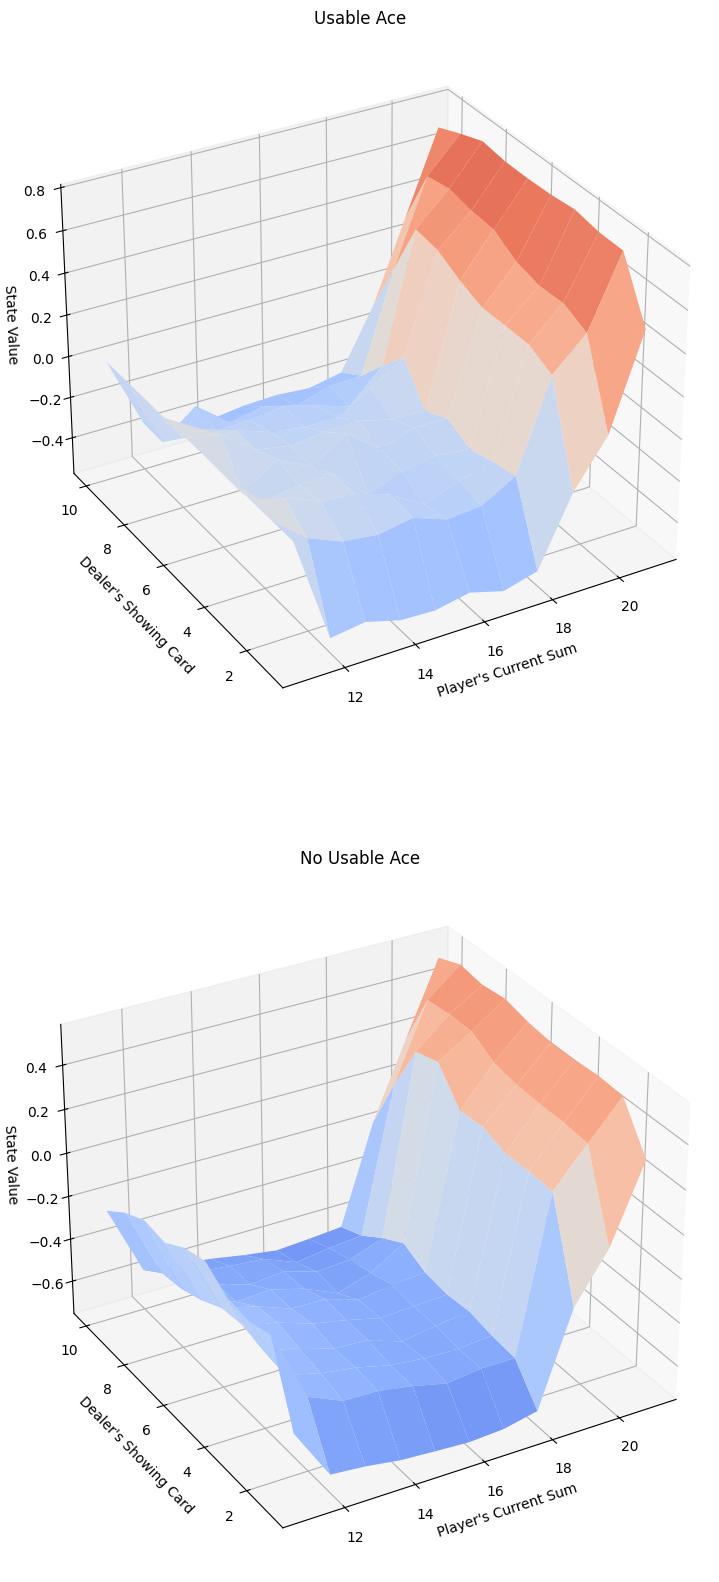

In [10]:
# obtain the action-value function
Q = mc_prediction_q(env, 500000, generate_episode_from_limit_stochastic)

# obtain the corresponding state-value function
V_to_plot = dict((k,(k[0]>18)*(np.dot([0.8, 0.2],v)) + (k[0]<=18)*(np.dot([0.2, 0.8],v))) \
         for k, v in Q.items())

# plot the state-value function
plot_blackjack_values(V_to_plot)

### Part 2: MC Control

In this section, you will write your own implementation of constant-$\alpha$ MC control.  

Your algorithm has four arguments:
- `env`: This is an instance of an OpenAI Gym environment.
- `num_episodes`: This is the number of episodes that are generated through agent-environment interaction.
- `alpha`: This is the step-size parameter for the update step.
- `gamma`: This is the discount rate.  It must be a value between 0 and 1, inclusive (default value: `1`).

The algorithm returns as output:
- `Q`: This is a dictionary (of one-dimensional arrays) where `Q[s][a]` is the estimated action value corresponding to state `s` and action `a`.
- `policy`: This is a dictionary where `policy[s]` returns the action that the agent chooses after observing state `s`.

(_Feel free to define additional functions to help you to organize your code._)

In [11]:
def generate_episode_from_Q(env, Q, epsilon, nA):
    """ generates an episode from following the epsilon-greedy policy """
    episode = []
    # Gymnasium returns (obs, info); Gym returns just obs
    state = env.reset()
    if isinstance(state, tuple):  # Gymnasium
        state = state[0]

    while True:
        action = (
            np.random.choice(np.arange(nA), p=get_probs(Q[state], epsilon, nA))
            if state in Q else env.action_space.sample()
        )

        step_out = env.step(action)
        if isinstance(step_out, tuple) and len(step_out) == 5:
            # Gymnasium: (obs, reward, terminated, truncated, info)
            next_state, reward, terminated, truncated, info = step_out
            done = terminated or truncated
        else:
            # Old Gym: (obs, reward, done, info)
            next_state, reward, done, info = step_out

        episode.append((state, action, reward))

        # normalize next_state like we did for reset()
        if isinstance(next_state, tuple):  # super defensive; shouldn't happen here
            next_state = next_state[0]

        state = next_state
        if done:
            break
    return episode

def get_probs(Q_s, epsilon, nA):
    """ obtains the action probabilities corresponding to epsilon-greedy policy """
    policy_s = np.ones(nA) * epsilon / nA
    best_a = np.argmax(Q_s)
    policy_s[best_a] = 1 - epsilon + (epsilon / nA)
    return policy_s

def update_Q(env, episode, Q, alpha, gamma):
    """ updates the action-value function estimate using the most recent episode """
    states, actions, rewards = zip(*episode)
    # prepare for discounting
    discounts = np.array([gamma**i for i in range(len(rewards)+1)])
    for i, state in enumerate(states):
        old_Q = Q[state][actions[i]]
        Q[state][actions[i]] = old_Q + alpha*(sum(rewards[i:]*discounts[:-(1+i)]) - old_Q)
    return Q

In [12]:
def mc_control(env, num_episodes, alpha, gamma=1.0, eps_start=1.0, eps_decay=.99999, eps_min=0.05):
    nA = env.action_space.n
    # initialize empty dictionary of arrays
    Q = defaultdict(lambda: np.zeros(nA))
    epsilon = eps_start
    # loop over episodes
    for i_episode in range(1, num_episodes+1):
        # monitor progress
        if i_episode % 1000 == 0:
            print("\rEpisode {}/{}.".format(i_episode, num_episodes), end="")
            sys.stdout.flush()
        # set the value of epsilon
        epsilon = max(epsilon*eps_decay, eps_min)
        # generate an episode by following epsilon-greedy policy
        episode = generate_episode_from_Q(env, Q, epsilon, nA)
        # update the action-value function estimate using the episode
        Q = update_Q(env, episode, Q, alpha, gamma)
    # determine the policy corresponding to the final action-value function estimate
    policy = dict((k,np.argmax(v)) for k, v in Q.items())
    return policy, Q

Use the cell below to obtain the estimated optimal policy and action-value function.  Note that you should fill in your own values for the `num_episodes` and `alpha` parameters.

In [13]:
# obtain the estimated optimal policy and action-value function
policy, Q = mc_control(env, 500000, 0.02)

Episode 500000/500000.

Next, we plot the corresponding state-value function.

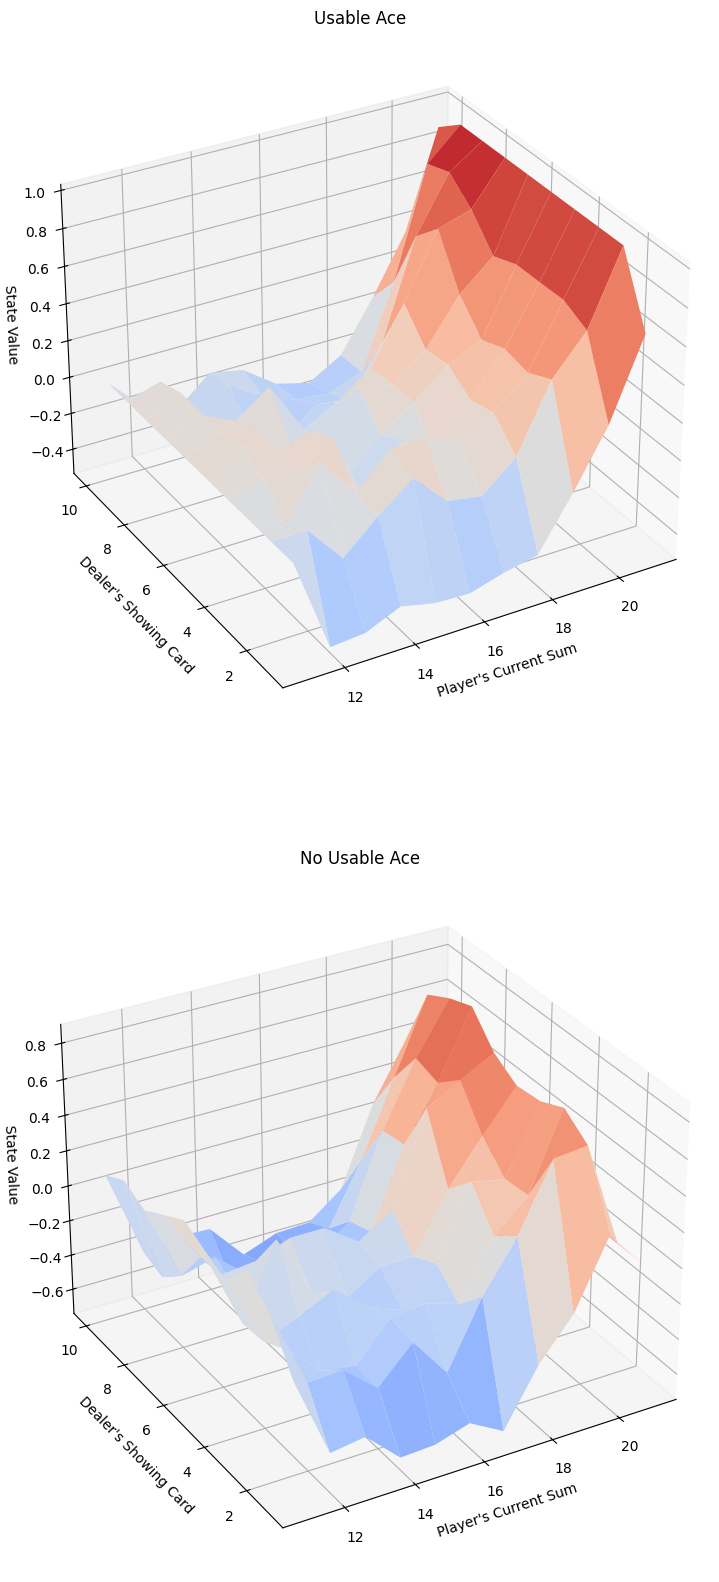

In [14]:
# obtain the corresponding state-value function
V = dict((k,np.max(v)) for k, v in Q.items())

# plot the state-value function
plot_blackjack_values(V)

Finally, we visualize the policy that is estimated to be optimal.

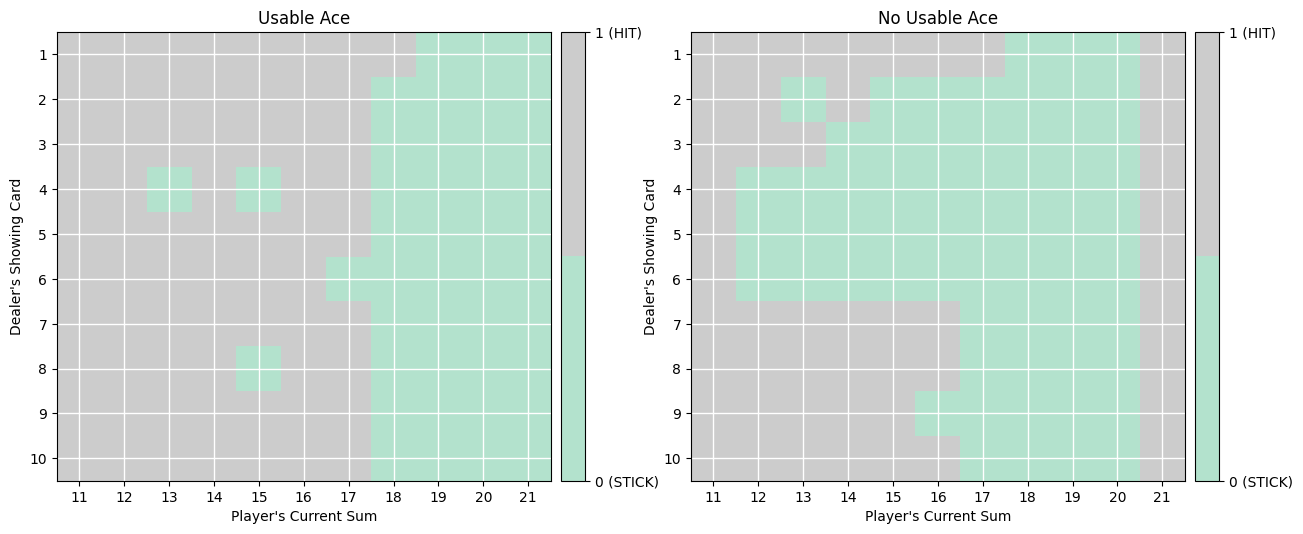

In [15]:
# plot the policy
plot_policy(policy)

The **true** optimal policy $\pi_*$ can be found in Figure 5.2 of the [textbook](http://go.udacity.com/rl-textbook) (and appears below).  Compare your final estimate to the optimal policy - how close are you able to get?  If you are not happy with the performance of your algorithm, take the time to tweak the decay rate of $\epsilon$, change the value of $\alpha$, and/or run the algorithm for more episodes to attain better results.

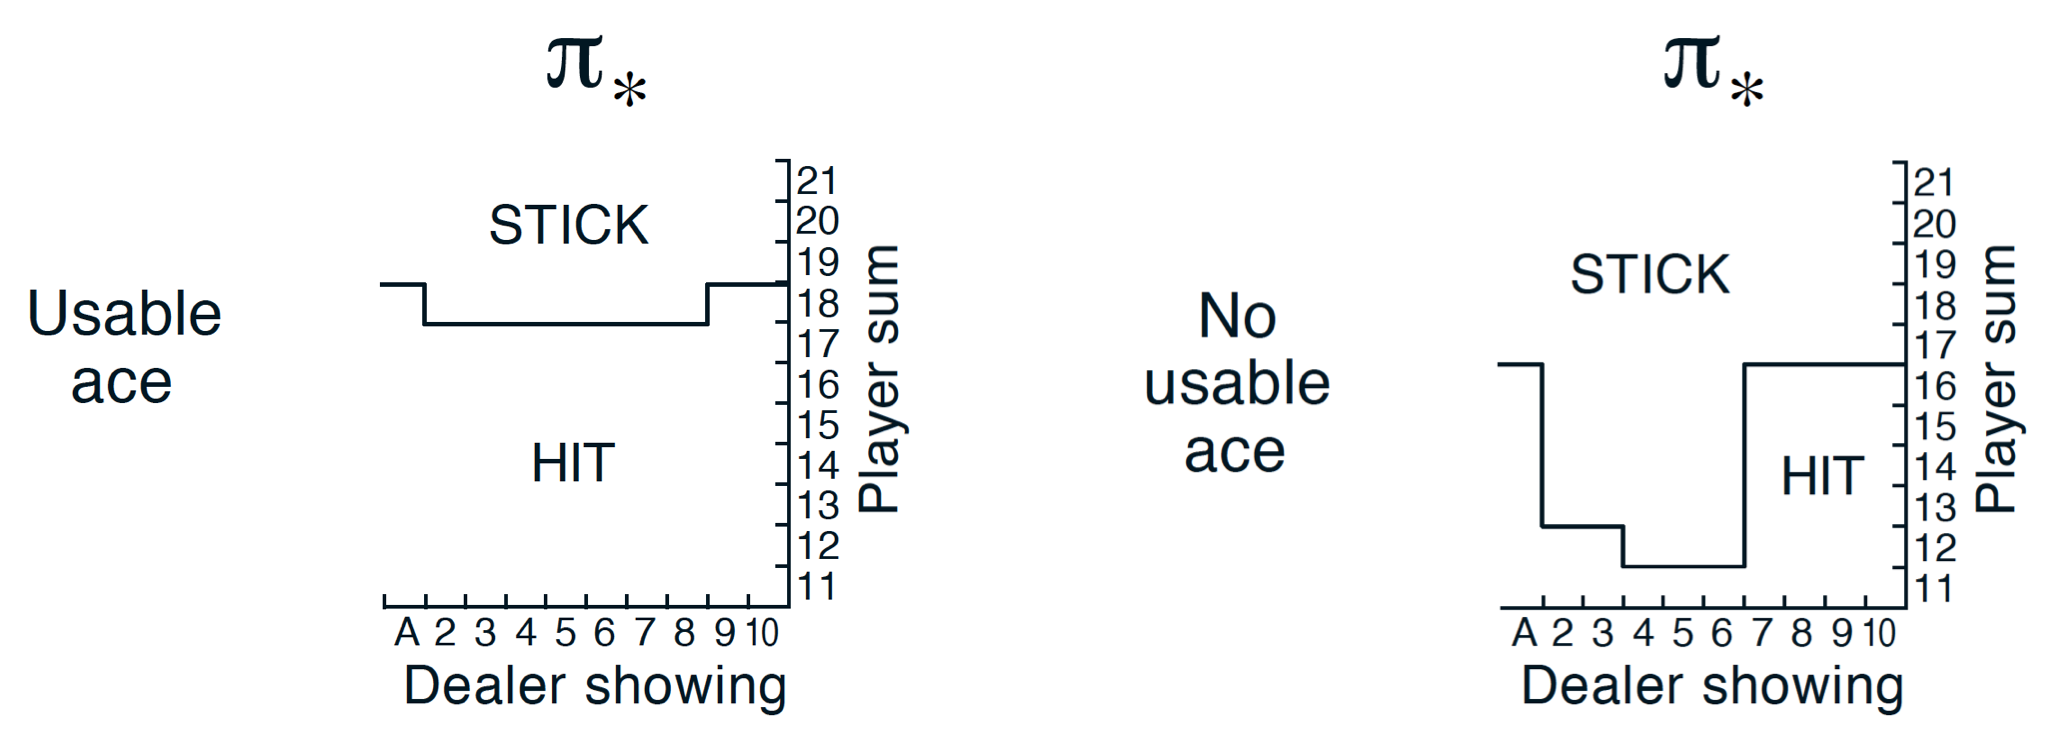


Simulation:

In [28]:
import random

def simulate_with_policy(env, policy_fn, n_episodes=10000, seed=None, verbose=False):
    """
    Simulate n_episodes using a deterministic/stochastic policy function: action = policy_fn(state).
    Returns empirical win/draw/loss rates and (optionally) prints a few example trajectories.
    """
    if seed is not None:
        random.seed(seed); np.random.seed(seed)
    wins = draws = losses = 0
    sample_trajs = []

    for ep in range(n_episodes):
        # In your current env API, reset() returns just state (not (obs, info))
        state = env.reset()
        traj = []
        done = False
        while not done:
            a = policy_fn(state)
            next_state, reward, done, info = env.step(a)
            traj.append((state, a, reward))
            state = next_state
        if reward > 0: wins += 1
        elif reward == 0: draws += 1
        else: losses += 1
        if verbose and ep < 3:
            sample_trajs.append(traj)

    rates = {
        "wins": wins / n_episodes,
        "draws": draws / n_episodes,
        "losses": losses / n_episodes,
        "n": n_episodes
    }
    if verbose:
        print("Sample trajectories (state, action, reward):")
        for i, tr in enumerate(sample_trajs, 1):
            print(f"Episode {i}:")
            for t in tr:
                print("   ", t)
        print()
    return rates

def random_policy_fn(state):
    """Uniformly random action: 0=STICK, 1=HIT."""
    return env.action_space.sample()

def limit_stochastic_policy_fn(state):
    """
    Your Part 1 fixed policy in function form (to use for fast simulation):
      if sum > 18: STICK with 0.8 (else HIT)
      else:        HIT with 0.8 (else STICK)
    """
    probs = [0.8, 0.2] if state[0] > 18 else [0.2, 0.8]
    return np.random.choice(np.arange(2), p=probs)


In [18]:
# A. Random baseline
rates_random = simulate_with_policy(env, random_policy_fn, n_episodes=20000, seed=42)
print("Random policy:", rates_random)

# B. Your 80/20 thresholdy policy
rates_limit = simulate_with_policy(env, limit_stochastic_policy_fn, n_episodes=20000, seed=42)
print("80/20 threshold policy:", rates_limit)


Random policy: {'wins': 0.2839, 'draws': 0.04005, 'losses': 0.67605, 'n': 20000}
80/20 threshold policy: {'wins': 0.32235, 'draws': 0.05645, 'losses': 0.6212, 'n': 20000}


In [19]:
def trace_one_episode_part1(env, Q_view=None, gamma=1.0):
    """
    Generates ONE episode with your fixed 80/20 policy, prints:
      - the trajectory (s, a, r)
      - the computed returns G_t for each step
      - the sample-average update that Part 1 would apply to Q(s,a)
    Q_view: optional dict-like to show "before/after" estimates; if None, a fresh local Q is used.
    """
    # Create an episode using your provided generator
    episode = generate_episode_from_limit_stochastic(env)

    print("Episode trajectory:")
    for t, (s, a, r) in enumerate(episode):
        print(f"  t={t}: state={s}, action={a}, reward={r}")
    print()

    # Compute returns G_t from that episode
    states, actions, rewards = zip(*episode)
    discounts = np.array([gamma**i for i in range(len(rewards)+1)])
    Gs = []
    for i in range(len(states)):
        G_i = float(np.sum(np.array(rewards[i:]) * discounts[:-(1+i)]))
        Gs.append(G_i)
    print("Returns G_t from each time step:")
    for i, G in enumerate(Gs):
        print(f"  G[{i}] = {G:.4f}")
    print()

    # Show how Part 1's sample-average update would change Q
    # We'll keep a local copy unless you pass an existing Q to inspect
    if Q_view is None:
        Q_view = defaultdict(lambda: np.zeros(env.action_space.n))
        returns_sum = defaultdict(lambda: np.zeros(env.action_space.n))
        N = defaultdict(lambda: np.zeros(env.action_space.n))
    else:
        # If you pass an existing Q, we still need local sums/counts to illustrate one update
        returns_sum = defaultdict(lambda: np.zeros(env.action_space.n))
        N = defaultdict(lambda: np.zeros(env.action_space.n))

    print("Sample-average updates that Part 1 would apply:")
    for i, s in enumerate(states):
        a = actions[i]
        old = Q_view[s][a]
        returns_sum[s][a] += Gs[i]
        N[s][a] += 1.0
        new = returns_sum[s][a] / N[s][a] if N[s][a] > 0 else old
        print(f"  (s={s}, a={a})  old Q={old:.4f}  ->  new Q~={new:.4f}  using G={Gs[i]:.4f}")
        # For illustration, write it so you can reuse Q_view afterwards if you want
        Q_view[s][a] = new

    return episode, Gs, Q_view

# Run the tracer once
_ = trace_one_episode_part1(env, Q_view=None, gamma=1.0)


Episode trajectory:
  t=0: state=(20, 9, False), action=0, reward=1.0

Returns G_t from each time step:
  G[0] = 1.0000

Sample-average updates that Part 1 would apply:
  (s=(20, 9, False), a=0)  old Q=0.0000  ->  new Q~=1.0000  using G=1.0000


In [29]:
# Train using your MC control
policy_learned, Q_learned = mc_control(env, num_episodes=200000, alpha=0.02, gamma=1.0)

def greedy_policy_from_dict(state):
    """Deterministic greedy policy from your learned 'policy' dict (fallback to HIT if unseen)."""
    return policy_learned.get(state, 1)  # if unseen state, default to HIT

# Evaluate learned policy vs baselines
rates_learned = simulate_with_policy(env, greedy_policy_from_dict, n_episodes=50000, seed=7)
print("Learned (greedy) policy:", rates_learned)
print("Baseline 80/20 policy:", simulate_with_policy(env, limit_stochastic_policy_fn, 50000, seed=7))
print("Random policy:", simulate_with_policy(env, random_policy_fn, 50000, seed=7))


Episode 200000/200000.

TypeError: unhashable type: 'dict'

In [ ]:
def trace_mc_control_first_k(env, k=3, alpha=0.2, gamma=1.0, eps_start=1.0, eps_decay=0.9, eps_min=0.1):
    """
    Mini MC-control run for k episodes with LARGE alpha/fast epsilon decay so you can watch learning.
    Prints:
      - epsilon per episode
      - action probabilities at visited states
      - episode trajectory
      - returns G_t
      - incremental Q updates (constant-alpha)
    """
    nA = env.action_space.n
    Q = defaultdict(lambda: np.zeros(nA))
    epsilon = eps_start

    for ep in range(1, k+1):
        print("="*60)
        print(f"Episode {ep} | epsilon={epsilon:.4f}")

        # Generate episode epsilon-greedily from current Q
        episode = []
        state = env.reset()
        done = False
        while not done:
            if state in Q:
                probs = get_probs(Q[state], epsilon, nA)
            else:
                probs = np.ones(nA) / nA  # unseen state → uniform
            action = np.random.choice(np.arange(nA), p=probs)
            next_state, reward, done, info = env.step(action)
            episode.append((state, action, reward))
            print(f"  state={state}, Q={Q[state]}, probs={probs} -> action={action}, reward={reward}")
            state = next_state

        # Compute returns
        states, actions, rewards = zip(*episode)
        discounts = np.array([gamma**i for i in range(len(rewards)+1)])
        Gs = [float(np.sum(np.array(rewards[i:]) * discounts[:-(1+i)])) for i in range(len(states))]
        print("  Returns G_t:", [f"{g:.3f}" for g in Gs])

        # Apply constant-alpha MC updates (same rule as your update_Q)
        for i, s in enumerate(states):
            a = actions[i]
            old_Q = Q[s][a]
            target = Gs[i]
            Q[s][a] = old_Q + alpha * (target - old_Q)
            print(f"  Update (s={s}, a={a}): old={old_Q:.3f} -> new={Q[s][a]:.3f}  (target G={target:.3f})")

        # decay epsilon
        epsilon = max(epsilon * eps_decay, eps_min)

    print("="*60)
    print("Finished tracing. Final few Q entries (sample):")
    c = 0
    for s, q in Q.items():
        print(" ", s, "->", q)
        c += 1
        if c >= 8: break
    return Q

# Run a tiny trace (use small k to keep output readable)
_ = trace_mc_control_first_k(env, k=3, alpha=0.2, gamma=1.0, eps_start=1.0, eps_decay=0.5, eps_min=0.1)


Episode 1 | epsilon=1.0000
  state=(15, 5, False), Q=[0. 0.], probs=[0.5 0.5] -> action=0, reward=1.0
  Returns G_t: ['1.000']
  Update (s=(15, 5, False), a=0): old=0.000 -> new=0.200  (target G=1.000)
Episode 2 | epsilon=0.5000
  state=(12, 8, False), Q=[0. 0.], probs=[0.5 0.5] -> action=1, reward=0.0
  state=(19, 8, False), Q=[0. 0.], probs=[0.5 0.5] -> action=0, reward=1.0
  Returns G_t: ['1.000', '1.000']
  Update (s=(12, 8, False), a=1): old=0.000 -> new=0.200  (target G=1.000)
  Update (s=(19, 8, False), a=0): old=0.000 -> new=0.200  (target G=1.000)
Episode 3 | epsilon=0.2500
  state=(20, 8, False), Q=[0. 0.], probs=[0.5 0.5] -> action=1, reward=-1.0
  Returns G_t: ['-1.000']
  Update (s=(20, 8, False), a=1): old=0.000 -> new=-0.200  (target G=-1.000)
Finished tracing. Final few Q entries (sample):
  (15, 5, False) -> [0.2 0. ]
  (12, 8, False) -> [0.  0.2]
  (19, 8, False) -> [0.2 0. ]
  (20, 8, False) -> [ 0.  -0.2]


PyGame

In [16]:
pip install pygame


[notice] A new release of pip is available: 25.0.1 -> 25.2
[notice] To update, run: python3 -m pip install --upgrade pip
Note: you may need to restart the kernel to use updated packages.


In [26]:
# Complete Blackjack Monte Carlo Learning Simulation with Fixed Layout
# Integrates your original MC control algorithm with live visualization

import pygame
import time
import numpy as np
import gym
from collections import defaultdict
import sys

# Handle numpy compatibility
if not hasattr(np, 'bool8'):
    np.bool8 = np.bool_

# Initialize environment
try:
    env = gym.make('Blackjack-v1')
    print("Environment created successfully!")
except Exception as e:
    print(f"Error creating environment: {e}")
    sys.exit(1)

# Learning parameters - using your original MC control parameters
LEARN_MODE = True
ALPHA = 0.02           # Learning rate from your original code
GAMMA = 1.0            # Discount factor
EPSILON_START = 1.0    # Initial exploration
EPSILON_DECAY = 0.99999 # Your original decay rate
EPSILON_MIN = 0.05     # Minimum exploration

# Global learning state - using your original MC control structure
Q_live = defaultdict(lambda: np.zeros(2))  # 2 actions: STICK, HIT
epsilon_current = EPSILON_START
episode_count = 0
total_wins = 0
total_losses = 0
total_draws = 0

def reset_learning():
    """Reset all learning progress"""
    global Q_live, epsilon_current, episode_count, total_wins, total_losses, total_draws
    Q_live = defaultdict(lambda: np.zeros(2))
    epsilon_current = EPSILON_START
    episode_count = 0
    total_wins = 0
    total_losses = 0
    total_draws = 0
    print("Learning reset!")

# Your original MC control helper functions
def get_probs(Q_s, epsilon, nA):
    """obtains the action probabilities corresponding to epsilon-greedy policy"""
    policy_s = np.ones(nA) * epsilon / nA
    best_a = np.argmax(Q_s)
    policy_s[best_a] = 1 - epsilon + (epsilon / nA)
    return policy_s

def generate_episode_from_Q(env, Q, epsilon, nA):
    """generates an episode from following the epsilon-greedy policy"""
    episode = []
    state = reset_env_safe(env)
    while True:
        action = np.random.choice(np.arange(nA), p=get_probs(Q[state], epsilon, nA)) \
                                    if state in Q else env.action_space.sample()
        next_state, reward, done, info = step_env_safe(env, action)
        episode.append((state, action, reward))
        state = next_state
        if done:
            break
    return episode

def update_Q_monte_carlo(env, episode, Q, alpha, gamma):
    """updates the action-value function estimate using Monte Carlo"""
    states, actions, rewards = zip(*episode)
    # prepare for discounting
    discounts = np.array([gamma**i for i in range(len(rewards)+1)])
    for i, state in enumerate(states):
        old_Q = Q[state][actions[i]]
        # Monte Carlo return calculation
        G = sum(rewards[i:]*discounts[:-(1+i)])
        Q[state][actions[i]] = old_Q + alpha*(G - old_Q)
    return Q

def collect_episode_with_mc_learning():
    """Run one episode with Monte Carlo learning - your original algorithm"""
    global Q_live, epsilon_current, episode_count, total_wins, total_losses, total_draws
    
    episode_count += 1
    epsilon_current = max(epsilon_current * EPSILON_DECAY, EPSILON_MIN)
    
    # Use your original episode generation method
    nA = env.action_space.n
    episode_data = generate_episode_from_Q(env, Q_live, epsilon_current, nA)
    
    # Detailed episode analysis for learning
    initial_state = episode_data[0][0] if episode_data else None
    actions_taken = [action for _, action, _ in episode_data]
    final_reward = episode_data[-1][2] if episode_data else 0
    
    # Update Q using Monte Carlo (your original method)
    if LEARN_MODE and episode_data:
        Q_live = update_Q_monte_carlo(env, episode_data, Q_live, ALPHA, GAMMA)
    
    # Update statistics based on final reward
    if final_reward > 0:
        total_wins += 1
        outcome = "WIN"
        outcome_emoji = "🎉"
    elif final_reward < 0:
        total_losses += 1
        outcome = "LOSS"
        outcome_emoji = "😞"
    else:
        total_draws += 1
        outcome = "DRAW"
        outcome_emoji = "😐"
    
    # Enhanced episode reporting
    total_games = total_wins + total_losses + total_draws
    win_rate = (total_wins / max(1, total_games)) * 100
    
    if initial_state:
        player_sum, dealer_card, usable_ace = initial_state
        actions_str = " → ".join(["HIT" if a == 1 else "STICK" for a in actions_taken])
        
        print(f"Episode {episode_count}: {outcome} {outcome_emoji}")
        print(f"  Game: Player {player_sum} vs Dealer {dealer_card} {'(usable ace)' if usable_ace else ''}")
        print(f"  Actions: {actions_str}")
        print(f"  Final reward: {final_reward}")
        print(f"  Running stats: {win_rate:.1f}% win rate | W:{total_wins} L:{total_losses} D:{total_draws}")
        
        # Show Q-value learning for this state
        if initial_state in Q_live:
            q_vals = Q_live[initial_state]
            stick_q, hit_q = q_vals[0], q_vals[1]
            best_action = "STICK" if stick_q > hit_q else "HIT"
            confidence = abs(stick_q - hit_q)
            print(f"  Learned Q-values: STICK={stick_q:.4f}, HIT={hit_q:.4f}")
            print(f"  Strategy: Prefer {best_action} (confidence: {confidence:.4f})")
        
        # Strategic analysis
        if player_sum >= 17:
            strategy_note = "High hand - should usually STICK"
        elif player_sum <= 11:
            strategy_note = "Low hand - should usually HIT"
        elif dealer_card in [2,3,4,5,6]:
            strategy_note = "Dealer weak - consider STICK"
        elif dealer_card in [7,8,9,10,1]:
            strategy_note = "Dealer strong - consider HIT"
        else:
            strategy_note = "Marginal situation"
            
        print(f"  Strategy insight: {strategy_note}")
        print(f"  Exploration: ε={epsilon_current:.4f} | States learned: {len(Q_live)}")
        print("-" * 60)
    
    # Convert to trajectory format for visualization
    trajectory = []
    for i, (state, action, reward) in enumerate(episode_data):
        is_final = (i == len(episode_data) - 1)
        
        # For final step, add detailed game explanation
        game_info = None
        if is_final:
            player_sum = state[0]
            dealer_card = state[1]
            
            # Determine what happened based on reward and player sum
            if final_reward > 0:
                if player_sum == 21 and len(episode_data) == 1:
                    game_info = f"BLACKJACK! Player: 21, Instant win!"
                elif player_sum <= 21:
                    game_info = f"Player: {player_sum}, Dealer busted or had worse hand"
                else:
                    game_info = f"ERROR: Player busted but got positive reward"
            elif final_reward < 0:
                if player_sum > 21:
                    game_info = f"Player busted with {player_sum}"
                else:
                    game_info = f"Player: {player_sum}, Dealer made better hand"
            else:
                game_info = f"PUSH - Both had same value around {player_sum}"
        
        trajectory.append({
            'state': state,
            'action': action,
            'reward': reward,
            'done': is_final,
            'step': i,
            'game_info': game_info
        })
    
    return trajectory

# Environment safety functions
def reset_env_safe(env):
    try:
        result = env.reset()
        if isinstance(result, tuple):
            return result[0]
        return result
    except Exception as e:
        print(f"Reset error: {e}")
        return (0, 0, 0)

def step_env_safe(env, action):
    try:
        result = env.step(action)
        if len(result) == 5:
            obs, reward, terminated, truncated, info = result
            done = terminated or truncated
            return obs, reward, done, info
        else:
            return result
    except Exception as e:
        print(f"Step error: {e}")
        return (0, 0, 0), -1, True, {}

# Initialize Pygame with better layout
pygame.init()
W, H = 1400, 900  # Bigger window to avoid overlap

try:
    screen = pygame.display.set_mode((W, H))
    pygame.display.set_caption("Monte Carlo Blackjack Learning - Live Training")
    clock = pygame.time.Clock()
    print("Pygame initialized successfully!")
except Exception as e:
    print(f"Pygame initialization error: {e}")
    sys.exit(1)

# Colors
GREEN = (20, 105, 60)
DARK = (10, 50, 30)
WHITE = (245, 245, 245)
YELLOW = (255, 210, 70)
RED = (220, 70, 70)
BLUE = (70, 140, 255)
GRAY = (180, 180, 180)
BLACK = (0, 0, 0)
ORANGE = (255, 165, 0)
PURPLE = (128, 0, 128)

# Initialize fonts
try:
    FONT = pygame.font.Font(None, 20)
    BIG = pygame.font.Font(None, 28)
    HUGE = pygame.font.Font(None, 42)
    print("Fonts loaded successfully!")
except Exception as e:
    print(f"Font loading error: {e}")
    FONT = pygame.font.Font(None, 20)
    BIG = pygame.font.Font(None, 28)
    HUGE = pygame.font.Font(None, 42)

def draw_card(x, y, text, face_up=True, highlight=False):
    """Draw a playing card"""
    color = WHITE if face_up else GRAY
    border_color = YELLOW if highlight else BLACK
    border_width = 4 if highlight else 2
    
    pygame.draw.rect(screen, color, (x, y, 70, 100), border_radius=8)
    pygame.draw.rect(screen, border_color, (x, y, 70, 100), border_width, border_radius=8)
    
    if face_up and str(text) != "?":
        text_color = RED if str(text) == "A" else BLACK
        label = BIG.render(str(text), True, text_color)
        text_rect = label.get_rect(center=(x + 35, y + 50))
        screen.blit(label, text_rect)
    elif not face_up:
        for i in range(7):
            pygame.draw.line(screen, BLUE, (x+6, y+12+i*12), (x+64, y+12+i*12), 2)

def draw_text(text, x, y, font=None, color=WHITE, center=False):
    """Helper to draw text safely"""
    if font is None:
        font = FONT
    try:
        surface = font.render(str(text), True, color)
        if center:
            rect = surface.get_rect(center=(x, y))
            screen.blit(surface, rect)
        else:
            screen.blit(surface, (x, y))
    except Exception as e:
        print(f"Text drawing error: {e}")

def draw_table_background():
    """Draw casino table with fixed layout"""
    screen.fill(DARK)
    # Main table area - adjusted to not overlap with panels
    pygame.draw.rect(screen, GREEN, (20, 20, W-320, H-40), border_radius=20)
    pygame.draw.rect(screen, BLACK, (20, 20, W-320, H-40), 4, border_radius=20)
    
    # Dividing lines
    table_center_y = H // 2
    pygame.draw.line(screen, DARK, (30, table_center_y), (W-330, table_center_y), 3)

def draw_learning_stats():
    """Draw learning statistics panel - fixed position"""
    # Position panel on the right side to avoid overlap
    stats_x = W - 290
    stats_y = 30
    panel_width = 270
    panel_height = 280
    
    pygame.draw.rect(screen, (40, 40, 40), (stats_x, stats_y, panel_width, panel_height), border_radius=10)
    pygame.draw.rect(screen, WHITE, (stats_x, stats_y, panel_width, panel_height), 2, border_radius=10)
    
    draw_text("MONTE CARLO LEARNING", stats_x + panel_width//2, stats_y + 20, BIG, YELLOW, center=True)
    
    total_games = total_wins + total_losses + total_draws
    win_rate = (total_wins / max(1, total_games)) * 100
    
    stats = [
        f"Episode: {episode_count}",
        f"Total Games: {total_games}",
        f"Wins: {total_wins} ({win_rate:.1f}%)",
        f"Losses: {total_losses}",
        f"Draws: {total_draws}",
        f"Epsilon (ε): {epsilon_current:.4f}",
        f"States Learned: {len(Q_live)}",
        f"Learning Rate (α): {ALPHA}",
        f"Algorithm: MC Control"
    ]
    
    colors = [WHITE, WHITE, GREEN, RED, ORANGE, BLUE, PURPLE, WHITE, YELLOW]
    
    for i, (stat, color) in enumerate(zip(stats, colors)):
        draw_text(stat, stats_x + 10, stats_y + 50 + i * 22, FONT, color)

def draw_q_values(state):
    """Draw Q-values panel - fixed position"""
    q_x = W - 290
    q_y = 340
    panel_width = 270
    panel_height = 180
    
    pygame.draw.rect(screen, (40, 40, 40), (q_x, q_y, panel_width, panel_height), border_radius=10)
    pygame.draw.rect(screen, WHITE, (q_x, q_y, panel_width, panel_height), 2, border_radius=10)
    
    draw_text("Q-VALUES (Action Values)", q_x + panel_width//2, q_y + 20, BIG, YELLOW, center=True)
    
    if state in Q_live:
        q_values = Q_live[state]
        q_stick = q_values[0]
        q_hit = q_values[1]
        best_action = np.argmax(q_values)
        
        stick_color = GREEN if best_action == 0 else WHITE
        hit_color = GREEN if best_action == 1 else WHITE
        
        draw_text(f"STICK (0): {q_stick:.4f}", q_x + 10, q_y + 50, FONT, stick_color)
        draw_text(f"HIT   (1): {q_hit:.4f}", q_x + 10, q_y + 75, FONT, hit_color)
        
        # Show value difference
        diff = abs(q_stick - q_hit)
        draw_text(f"Confidence: {diff:.4f}", q_x + 10, q_y + 100, FONT, WHITE)
        
        preferred = "STICK" if best_action == 0 else "HIT"
        draw_text(f"Preferred: {preferred}", q_x + 10, q_y + 125, FONT, GREEN)
        
        # Show exploration vs exploitation
        if np.random.random() < epsilon_current:
            draw_text("Mode: EXPLORING", q_x + 10, q_y + 150, FONT, ORANGE)
        else:
            draw_text("Mode: EXPLOITING", q_x + 10, q_y + 150, FONT, GREEN)
    else:
        draw_text("State not learned yet", q_x + 10, q_y + 50, FONT, GRAY)
        draw_text("Will explore randomly", q_x + 10, q_y + 75, FONT, GRAY)

def draw_policy_hint():
    """Draw policy learning hints"""
    hint_x = W - 290
    hint_y = 540
    panel_width = 270
    panel_height = 120
    
    pygame.draw.rect(screen, (30, 30, 60), (hint_x, hint_y, panel_width, panel_height), border_radius=10)
    pygame.draw.rect(screen, BLUE, (hint_x, hint_y, panel_width, panel_height), 2, border_radius=10)
    
    draw_text("BASIC STRATEGY GUIDE", hint_x + panel_width//2, hint_y + 15, BIG, YELLOW, center=True)
    
    hints = [
        "Hard 17+: Always STICK",
        "Hard 11-: Always HIT", 
        "Hard 12-16: Depends on dealer",
        "Soft hands: More flexible"
    ]
    
    for i, hint in enumerate(hints):
        draw_text(hint, hint_x + 10, hint_y + 40 + i * 18, FONT, WHITE)

def draw_game_state(transition, show_thinking=False):
    """Draw current game state with complete game information"""
    state = transition['state']
    action = transition['action']
    reward = transition['reward']
    done = transition['done']
    game_info = transition.get('game_info', None)
    
    player_sum, dealer_card, usable_ace = state
    
    draw_table_background()
    
    # Title - positioned to not overlap with panels
    draw_text("MONTE CARLO BLACKJACK LEARNING", (W-320)//2, 40, HUGE, WHITE, center=True)
    draw_text("Watch Your Agent Learn Optimal Strategy", (W-320)//2, 80, BIG, YELLOW, center=True)
    
    # Dealer section
    draw_text("DEALER", 80, 120, BIG, WHITE)
    draw_card(80, 150, dealer_card, face_up=True)
    draw_card(160, 150, "?", face_up=False)
    
    # Show dealer's likely range
    draw_text(f"Showing: {dealer_card}", 80, 270, FONT, WHITE)
    if dealer_card in [2, 3, 4, 5, 6]:
        draw_text("(Weak - may bust)", 80, 290, FONT, ORANGE)
    elif dealer_card in [7, 8, 9, 10, 1]:
        draw_text("(Strong card)", 80, 290, FONT, RED)
    
    # Player section
    draw_text("AI AGENT", 80, 350, BIG, WHITE)
    draw_card(80, 380, player_sum, face_up=True, highlight=True)
    draw_card(160, 380, "?", face_up=True)
    
    # Game info
    info_y = 520
    draw_text(f"Player Sum: {player_sum}", 80, info_y, BIG, WHITE)
    draw_text(f"Dealer Showing: {dealer_card}", 80, info_y + 30, FONT, WHITE)
    draw_text(f"Usable Ace: {'Yes' if usable_ace else 'No'}", 80, info_y + 55, FONT, WHITE)
    
    # State encoding
    draw_text(f"State: ({player_sum}, {dealer_card}, {int(usable_ace)})", 80, info_y + 80, FONT, GRAY)
    
    # Action/thinking display
    if show_thinking:
        draw_text("AGENT THINKING...", 350, 280, HUGE, YELLOW)
        draw_text("Consulting Q-table", 350, 320, BIG, ORANGE)
        
        # Show current strategy knowledge
        if state in Q_live:
            q_vals = Q_live[state]
            best_action = np.argmax(q_vals)
            confidence = abs(q_vals[0] - q_vals[1])
            
            if confidence > 0.1:
                decision_type = "High confidence"
                decision_color = GREEN
            elif confidence > 0.05:
                decision_type = "Medium confidence"  
                decision_color = YELLOW
            else:
                decision_type = "Low confidence"
                decision_color = ORANGE
                
            draw_text(f"{decision_type} decision", 350, 350, BIG, decision_color)
            
            if best_action == 0:
                draw_text("Leaning towards STICK", 350, 380, BIG, RED)
            else:
                draw_text("Leaning towards HIT", 350, 380, BIG, BLUE)
        else:
            draw_text("New situation - exploring", 350, 350, BIG, ORANGE)
        
        # Show exploration vs exploitation decision
        explore_prob = epsilon_current * 100
        draw_text(f"Exploration chance: {explore_prob:.1f}%", 350, 410, FONT, ORANGE)
        
    else:
        action_text = "STICK" if action == 0 else "HIT"
        action_color = RED if action == 0 else BLUE
        draw_text(f"ACTION: {action_text}", 350, 280, HUGE, action_color)
        
        # Show reasoning
        if state in Q_live:
            q_vals = Q_live[state]
            stick_q = q_vals[0]
            hit_q = q_vals[1]
            draw_text(f"STICK Q: {stick_q:.3f}", 350, 320, FONT, WHITE)
            draw_text(f"HIT Q: {hit_q:.3f}", 350, 340, FONT, WHITE)
            
            # Show if this was exploration or exploitation
            best_action = np.argmax(q_vals)
            if (action == best_action):
                draw_text("(Exploiting best action)", 350, 360, FONT, GREEN)
            else:
                draw_text("(Exploring alternative)", 350, 360, FONT, ORANGE)
    
    # Result and detailed explanation if game is done
    if done:
        result_y = 180
        if reward > 0:
            draw_text("AGENT WINS!", (W-320)//2, result_y, HUGE, YELLOW, center=True)  # Changed to YELLOW for visibility
            draw_text("Reward: +1", (W-320)//2, result_y + 40, BIG, YELLOW, center=True)
        elif reward < 0:
            draw_text("AGENT LOSES", (W-320)//2, result_y, HUGE, RED, center=True)
            draw_text("Reward: -1", (W-320)//2, result_y + 40, BIG, RED, center=True)
        else:
            draw_text("PUSH (TIE)", (W-320)//2, result_y, HUGE, ORANGE, center=True)
            draw_text("Reward: 0", (W-320)//2, result_y + 40, BIG, ORANGE, center=True)
        
        # Show detailed game explanation
        if game_info:
            draw_text("GAME BREAKDOWN:", 350, 440, BIG, YELLOW)
            # Split long text into multiple lines
            words = game_info.split(' ')
            line1 = ' '.join(words[:4])
            line2 = ' '.join(words[4:]) if len(words) > 4 else ""
            
            draw_text(line1, 350, 470, FONT, WHITE)
            if line2:
                draw_text(line2, 350, 490, FONT, WHITE)
            
            # Add strategy insight
            if player_sum > 21:
                draw_text("Strategy: Busting is always bad", 350, 520, FONT, RED)
            elif player_sum >= 17:
                draw_text("Strategy: High hands usually stick", 350, 520, FONT, GREEN)
            elif player_sum <= 11:
                draw_text("Strategy: Low hands usually hit", 350, 520, FONT, BLUE)
            else:
                draw_text("Strategy: Depends on dealer card", 350, 520, FONT, ORANGE)
    
    # Draw all panels
    draw_learning_stats()
    draw_q_values(state)
    draw_policy_hint()
    
    # Controls - bottom of screen
    draw_text("Controls: SPACE=step | A=auto | R=reset | +/-=speed | ESC=quit", 30, H-30, FONT, GRAY)

def run_learning_episode(autoplay=True, step_delay=1.0):
    """Run one episode with Monte Carlo learning visualization"""
    trajectory = collect_episode_with_mc_learning()
    
    if not trajectory:
        return "RESTART"
    
    for i, transition in enumerate(trajectory):
        # Show thinking phase - longer duration for readability
        thinking_time = max(step_delay * 0.8, 1.5)  # At least 1.5 seconds to read
        draw_game_state(transition, show_thinking=True)
        pygame.display.flip()
        
        # Handle events during thinking phase
        start_time = time.time()
        while time.time() - start_time < thinking_time:
            for event in pygame.event.get():
                if event.type == pygame.QUIT:
                    return "QUIT"
                if event.type == pygame.KEYDOWN:
                    if event.key == pygame.K_ESCAPE:
                        return "QUIT"
                    elif event.key == pygame.K_SPACE:
                        autoplay = False
                        thinking_time = 0  # Skip thinking phase
                        break
                    elif event.key == pygame.K_a:
                        autoplay = not autoplay
            time.sleep(0.1)  # Small sleep to prevent high CPU usage
        
        # Show action taken
        draw_game_state(transition, show_thinking=False)
        pygame.display.flip()
        
        # Handle events
        for event in pygame.event.get():
            if event.type == pygame.QUIT:
                return "QUIT"
            if event.type == pygame.KEYDOWN:
                if event.key == pygame.K_ESCAPE:
                    return "QUIT"
                elif event.key == pygame.K_SPACE:
                    autoplay = False
                elif event.key == pygame.K_a:
                    autoplay = not autoplay
                elif event.key == pygame.K_r:
                    reset_learning()
                    return "RESTART"
                elif event.key == pygame.K_EQUALS:
                    step_delay = max(0.1, step_delay - 0.2)
                elif event.key == pygame.K_MINUS:
                    step_delay = min(3.0, step_delay + 0.2)
        
        # Manual stepping mode
        if not autoplay:
            waiting = True
            while waiting:
                for event in pygame.event.get():
                    if event.type == pygame.QUIT:
                        return "QUIT"
                    if event.type == pygame.KEYDOWN:
                        if event.key == pygame.K_SPACE:
                            waiting = False
                        elif event.key == pygame.K_a:
                            autoplay = True
                            waiting = False
                        elif event.key == pygame.K_ESCAPE:
                            return "QUIT"
                        elif event.key == pygame.K_r:
                            reset_learning()
                            return "RESTART"
                clock.tick(60)
        else:
            time.sleep(step_delay)
    
    # Show final result longer
    time.sleep(step_delay * 2)
    return "DONE"

def main_learning_loop():
    """Main Monte Carlo learning simulation loop"""
    print("\n🎰 Monte Carlo Blackjack Learning Simulation!")
    print("Watch your agent learn optimal Blackjack strategy using Monte Carlo control!")
    print("\nThis uses your original MC control algorithm:")
    print(f"- Learning rate (α): {ALPHA}")
    print(f"- Epsilon decay: {EPSILON_DECAY}")
    print(f"- Monte Carlo returns for Q-value updates")
    print("\nControls:")
    print("- SPACE: Manual step")
    print("- A: Toggle auto mode")
    print("- R: Reset learning")
    print("- +/-: Change speed")
    print("- ESC: Quit")
    
    autoplay = True
    step_delay = 1.2
    running = True
    
    reset_learning()
    
    while running:
        try:
            status = run_learning_episode(autoplay=autoplay, step_delay=step_delay)
            
            if status == "QUIT":
                running = False
            elif status == "RESTART":
                continue
            else:
                time.sleep(0.3)
                
                # Progress updates - enhanced with more details
                if episode_count % 10 == 0:
                    total_games = total_wins + total_losses + total_draws
                    win_rate = (total_wins / max(1, total_games)) * 100
                    
                    print(f"\n--- LEARNING PROGRESS UPDATE ---")
                    print(f"Episodes completed: {episode_count}")
                    print(f"Overall win rate: {win_rate:.1f}%")
                    print(f"Breakdown: {total_wins}W / {total_losses}L / {total_draws}D")
                    print(f"Exploration rate (ε): {epsilon_current:.4f}")
                    print(f"States in Q-table: {len(Q_live)}")
                    print(f"Learning rate (α): {ALPHA}")
                    
                    # Show some example Q-values
                    if len(Q_live) > 0:
                        print("Sample learned strategies:")
                        count = 0
                        for state, q_vals in Q_live.items():
                            if count < 3:
                                best_action = "STICK" if np.argmax(q_vals) == 0 else "HIT"
                                confidence = abs(q_vals[0] - q_vals[1])
                                print(f"  State {state}: {best_action} (confidence: {confidence:.3f})")
                                count += 1
                    print("-------------------------------\n")
                    
        except Exception as e:
            print(f"Episode error: {e}")
            time.sleep(1)
            continue
    
    pygame.quit()
    
    # Final statistics
    total_games = total_wins + total_losses + total_draws
    if total_games > 0:
        final_win_rate = (total_wins / total_games) * 100
        print(f"\n🎯 Monte Carlo Learning Complete!")
        print(f"Episodes: {episode_count}")
        print(f"Final Win Rate: {final_win_rate:.1f}%")
        print(f"States Learned: {len(Q_live)}")
        print(f"Final Epsilon: {epsilon_current:.4f}")
        
        # Show some learned Q-values
        print(f"\nSample Learned Q-values:")
        count = 0
        for state, q_vals in Q_live.items():
            if count < 5:
                best_action = "STICK" if np.argmax(q_vals) == 0 else "HIT"
                print(f"State {state}: STICK={q_vals[0]:.3f}, HIT={q_vals[1]:.3f} → {best_action}")
                count += 1

if __name__ == "__main__":
    print("Testing Monte Carlo environment...")
    test_state = reset_env_safe(env)
    print(f"Initial state: {test_state}")
    
    print("Starting Monte Carlo learning simulation...")
    main_learning_loop()

Environment created successfully!
Pygame initialized successfully!
Fonts loaded successfully!
Testing Monte Carlo environment...
Initial state: (8, 1, False)
Starting Monte Carlo learning simulation...

🎰 Monte Carlo Blackjack Learning Simulation!
Watch your agent learn optimal Blackjack strategy using Monte Carlo control!

This uses your original MC control algorithm:
- Learning rate (α): 0.02
- Epsilon decay: 0.99999
- Monte Carlo returns for Q-value updates

Controls:
- SPACE: Manual step
- A: Toggle auto mode
- R: Reset learning
- +/-: Change speed
- ESC: Quit
Learning reset!
Episode 1: LOSS 😞
  Game: Player 16 vs Dealer 10 
  Actions: HIT → HIT → HIT
  Final reward: -1.0
  Running stats: 0.0% win rate | W:0 L:1 D:0
  Learned Q-values: STICK=0.0000, HIT=-0.0200
  Strategy: Prefer STICK (confidence: 0.0200)
  Strategy insight: Dealer strong - consider HIT
  Exploration: ε=1.0000 | States learned: 3
------------------------------------------------------------
Episode 2: LOSS 😞
  Game

KeyboardInterrupt: 

In [32]:
import gym
import numpy as np
from collections import defaultdict

env = gym.make('Blackjack-v1')   # <- this must have run first


# ===========================
# MATPLOTLIB ANIMATOR (Notebook/Colab safe)
# Builds on your existing env/policies. No rewrites needed.
# ===========================
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import patches
from matplotlib import animation
from IPython.display import HTML, display

# --- Policies using your existing variables ---
def policy_random(state):
    return env.action_space.sample()

def policy_limit_80_20(state):
    state = _obs_only(state)
    probs = [0.8, 0.2] if state[0] > 18 else [0.2, 0.8]  # [STICK, HIT]
    return int(np.random.choice(np.arange(2), p=probs))

def policy_greedy_from_learned(state):
    # Uses your learned 'policy' dict if available; else falls back to HIT or threshold
    try:
        if 'policy' in globals() and policy is not None:
            return policy.get(state, int(np.argmax(Q.get(state, np.zeros(2)))))
        else:
            return policy_limit_80_20(state)
    except NameError:
        return policy_limit_80_20(state)

# --- Collect one episode's trajectory under a policy ---
def run_episode_collect(env, policy_fn):
    traj = []
    state = env.reset()
    done = False
    while not done:
        action = int(policy_fn(state))
        next_state, reward, done, info = env.step(action)
        traj.append((state, action, reward, done))
        state = next_state
    return traj  # list of (s, a, r, done) per step

# --- Simple “table” renderer helpers ---
def draw_table(ax):
    ax.clear()
    ax.set_xlim(0, 10)
    ax.set_ylim(0, 6)
    ax.axis('off')
    # table background
    ax.add_patch(patches.FancyBboxPatch((0.3,0.3), 9.4, 5.4, boxstyle="round,pad=0.02",
                                        edgecolor="black", facecolor="#2e8b57", linewidth=2))
    # divider
    ax.plot([0.4, 9.6], [3, 3], color="#1b5e3a", linewidth=3)
    ax.text(5, 5.6, "Dealer", ha="center", va="center", color="white", fontsize=20, fontweight="bold")
    ax.text(5, 0.7, "Player", ha="center", va="center", color="white", fontsize=20, fontweight="bold")

def card(ax, xy, text, face_up=True):
    x, y = xy
    rect = patches.FancyBboxPatch((x,y), 1.4, 2.0, boxstyle="round,pad=0.02",
                                  edgecolor="black", facecolor=("white" if face_up else "#b0b0b0"), linewidth=2)
    ax.add_patch(rect)
    if face_up:
        ax.text(x+0.7, y+1.0, str(text), ha="center", va="center", color="black", fontsize=16, fontweight="bold")
    else:
        # simple hatch pattern
        for k in range(5):
            ax.plot([x+0.2, x+1.2], [y+0.5+0.3*k, y+0.5+0.3*k], color="#3b7ddd", linewidth=2)

# Pull Q row if available (for HUD)
def get_Q_row(state):
    try:
        return Q.get(state, np.zeros(2))
    except NameError:
        return np.zeros(2)

# --- Animator ---
def animate_episode(policy_name="limit_80_20", fps=2):
    # Choose policy
    if policy_name == "random":
        policy_fn = policy_random
    elif policy_name == "greedy_learned":
        policy_fn = policy_greedy_from_learned
    else:
        policy_fn = policy_limit_80_20  # default

    # Run one episode and store frames data
    traj = run_episode_collect(env, policy_fn)      # [(s,a,r,done), ...]
    T = len(traj)

    fig, ax = plt.subplots(figsize=(9,5))
    draw_table(ax)

    # HUD text objects we’ll update
    hud_texts = {
        "ps": ax.text(1.0, 2.4, "", color="white", fontsize=14),
        "du": ax.text(1.0, 2.1, "", color="white", fontsize=14),
        "ua": ax.text(1.0, 1.8, "", color="white", fontsize=14),
        "qa": ax.text(6.6, 2.4, "", color="white", fontsize=14),
        "qb": ax.text(6.6, 2.1, "", color="white", fontsize=14),
        "act": ax.text(5, 3.2, "", ha="center", va="center", color="yellow", fontsize=18, fontweight="bold"),
        "rew": ax.text(5, 3.2, "", ha="center", va="center", color="yellow", fontsize=22, fontweight="bold"),
        "pol": ax.text(0.6, 5.6, f"Policy: {policy_name}", color="white", fontsize=14),
    }

    # Static dealer cards (upcard + face-down)
    def draw_static_cards(state):
        dealer_up = state[1]
        card(ax, (4.0, 3.5), dealer_up, face_up=True)
        card(ax, (5.8, 3.5), "?", face_up=False)
        # Player placeholder cards
        card(ax, (4.0, 0.8), "?", face_up=True)
        card(ax, (5.8, 0.8), "?", face_up=True)

    # INIT function for FuncAnimation
    def init():
        draw_table(ax)
        if T > 0:
            draw_static_cards(traj[0][0])
        return []

    # UPDATE frames: i = 0..T  (last frame shows terminal reward)
    def update(i):
        draw_table(ax)
        # choose state to show
        if i < T:
            state, action, reward, done = traj[i]
        else:
            state, action, reward, done = traj[-1]
        draw_static_cards(state)

        ps, du, ua = state
        q_row = get_Q_row(state)

        # Update HUD
        hud_texts["ps"].set_text(f"Player sum: {ps}")
        hud_texts["du"].set_text(f"Dealer upcard: {du}")
        hud_texts["ua"].set_text(f"Usable Ace: {'Yes' if ua else 'No'}")
        hud_texts["qa"].set_text(f"Q[STICK=0]: {q_row[0]: .3f}")
        hud_texts["qb"].set_text(f"Q[HIT=1]  : {q_row[1]: .3f}")

        # Action / reward banners
        if i < T:
            hud_texts["act"].set_text("Action: " + ("STICK" if action==0 else "HIT"))
            hud_texts["rew"].set_text("")
        else:
            # terminal
            R = traj[-1][2]
            if R > 0: txt, col = "WIN +1", "#ffd95a"
            elif R == 0: txt, col = "PUSH 0", "white"
            else: txt, col = "LOSS -1", "#ff6b6b"
            hud_texts["act"].set_text("")
            hud_texts["rew"].set_text(txt)
            hud_texts["rew"].set_color(col)

        # draw all text
        for k in hud_texts:
            ax.add_artist(hud_texts[k])

        return list(hud_texts.values())

    # Build animation (T steps + 1 terminal frame)
    anim = animation.FuncAnimation(fig, update, init_func=init,
                                   frames=T+1, interval=1000//max(1,fps), blit=False, repeat=False)
    plt.close(fig)
    return anim

# ===== How to use =====
# 1) Just run one:
anim = animate_episode(policy_name="limit_80_20", fps=2)  # options: "random", "limit_80_20", "greedy_learned"
display(HTML(anim.to_jshtml()))

# 2) If you already trained MC control (policy, Q = mc_control(...)), try:
# anim = animate_episode(policy_name="greedy_learned", fps=2)
# display(HTML(anim.to_jshtml()))

# 3) Save to MP4 (optional; needs ffmpeg in PATH):
# anim.save("blackjack_episode.mp4", writer="ffmpeg", fps=2, dpi=150)


NameError: name '_obs_only' is not defined